In [2]:
%matplotlib inline

#%% 3-rd party libraries

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from sklearn.decomposition import PCA
# import pydot_ng
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

In [3]:
#%% Defined functions

def missing_data_by_cols(df):
    """
    Returns a pandas data frame with the columns and the percentage of missing data for each column.
    """
    missing = 100 - np.array([df[c].notnull().sum()*100.0 / df.shape[0] for c in df.columns])
    return pd.DataFrame({'Column':df.columns, 'Missing %':missing})
    

def binarize_label_columns(df, columns, two_classes_as='single'):
    '''
    Inputs:
        df: Pandas dataframe object.
        columns: Columns to binarize.
        tow_classes_as: How to handle two classes, as 'single' or 'multiple' columns.
    Returns a tuple with the following items:
        df: Pandas dataframe object with new columns.
        binlabel_names: Names of the newly created binary variables.
        lb_objects: a dictionary with columns as keys and sklear.LabelBinarizer 
        objects as values.
    '''
    binlabel_names = []
    lb_objects = {}
    for col in columns:
        if len(df[col].unique()) > 1: 
            rows_notnull = df[col].notnull() # Use only valid feature observations
            lb = LabelBinarizer()
            binclass = lb.fit_transform(df[col][rows_notnull]) # Fit & transform on valid observations
            if len(lb.classes_) == 2 and two_classes_as == 'multiple':
                binclass = np.hstack((1 - binclass, binclass))
            lb_objects[col] = lb
            if len(lb.classes_) > 2 or two_classes_as == 'multiple':
                col_binlabel_names = [col+'_'+str(c) for c in lb.classes_]
                binlabel_names += col_binlabel_names # Names for the binarized classes
                for n in col_binlabel_names: df[n] = np.NaN # Initialize columns
                df.loc[rows_notnull, col_binlabel_names] = binclass # Merge binarized data
            elif two_classes_as == 'single': 
                binlabel_names.append(col+'_bin') # Names for the binarized classes
                df[col+'_bin'] = np.NaN # Initialize columns
                df.loc[rows_notnull, col+'_bin'] = binclass # Merge binarized data
    return df, binlabel_names, lb_objects

In [4]:
#%% Read the data

df = pd.read_csv('data_titanic.csv')

print df.dtypes
print missing_data_by_cols(df)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
         Column  Missing %
0   PassengerId   0.000000
1      Survived   0.000000
2        Pclass   0.000000
3          Name   0.000000
4           Sex   0.000000
5           Age  19.865320
6         SibSp   0.000000
7         Parch   0.000000
8        Ticket   0.000000
9          Fare   0.000000
10        Cabin  77.104377
11     Embarked   0.224467


In [5]:
#%% Clean dataset

# Remove columns that are obviously irrelevant
df.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Fill missing data using groups mean
df[['Sex','Age']].groupby('Sex').mean() # Means by group

# Fill each group's NA's with the group mean
f = lambda x: x.fillna(x.mean())
df['Age'] = df[['Sex','Age']].groupby('Sex').transform(f)

# Drop any NA's remaining
df.dropna(axis=0, inplace=True)

# Define numerical features
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare']

# Normalize
scaler = StandardScaler()
df.loc[:,numerical_features] = scaler.fit_transform(df[numerical_features])

# Softmax normalization
df.loc[:,numerical_features] = expit(df[numerical_features].values)*2.0 - 1.0

# Binarize categorical columns
label_columns = ['Embarked','Sex', 'Pclass']
df, binlabel_features, lb_objects = binarize_label_columns(df, label_columns, two_classes_as='multiple')

df.drop(['Embarked','Sex'], axis=1, inplace=True)

print missing_data_by_cols(df)

        Column  Missing %
0     Survived          0
1       Pclass          0
2          Age          0
3        SibSp          0
4        Parch          0
5         Fare          0
6   Embarked_C          0
7   Embarked_Q          0
8   Embarked_S          0
9   Sex_female          0
10    Sex_male          0
11    Pclass_1          0
12    Pclass_2          0
13    Pclass_3          0


In [6]:
#%% Segregate the data

survived_groups = df.groupby('Survived')

non_survived = survived_groups.get_group(0) 
survived = survived_groups.get_group(1) 

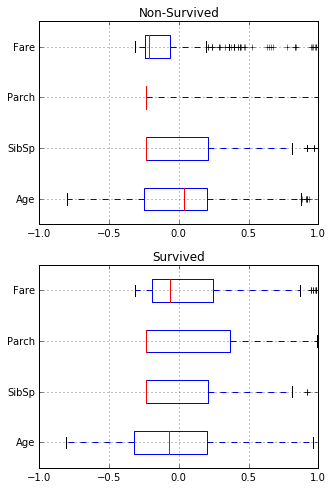

In [7]:
#%% Box plots for multiple features

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols = 1, figsize=(5,8))

non_survived[numerical_features].plot(kind='box', vert=False, ax=ax1)
ax1.set_title('Non-Survived')
ax1.grid(True)

survived[numerical_features].plot(kind='box', vert=False, ax=ax2)
ax2.set_title('Survived')
ax2.grid(True)

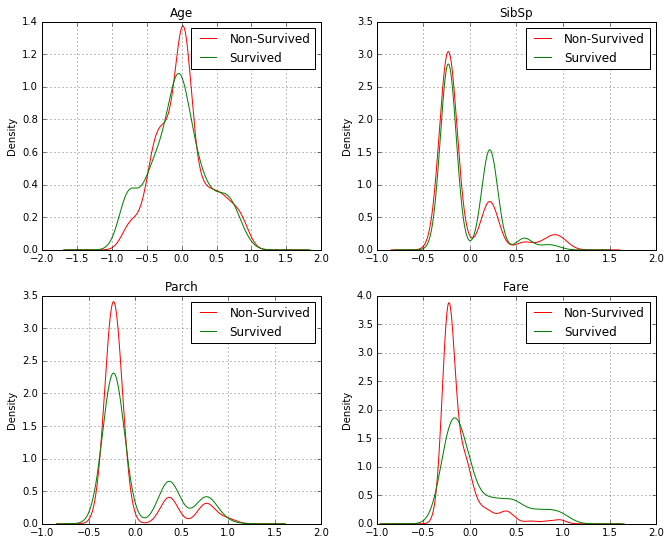

In [8]:
#%% Density plots for multiple features

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(11,9))

for f,ax in zip(numerical_features,(ax1,ax2,ax3,ax4)):
    # Plot density of non-survived
    non_survived[f].plot(kind='kde', ax=ax, color='r', label='Non-Survived')
    ax.set_title(f)
    ax.grid(True)
    # Plot density of survived
    survived[f].plot(kind='kde', ax=ax, color='g', label='Survived')
    ax.set_title(f)
    ax.grid(True)
    ax.legend(loc='best')

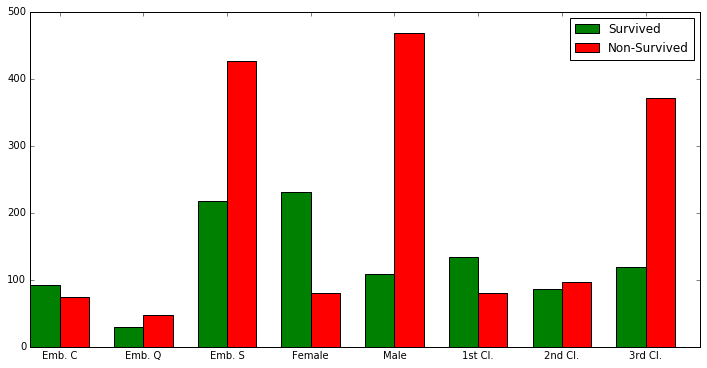

In [9]:
#%% Bar Plots

N = len(binlabel_features)

ind = np.arange(N)  # the x locations for the groups
ind = ind
width = 0.35       # the width of the bars

# Sum failures by category
survived_sum = df[['Survived']+binlabel_features].groupby('Survived').sum()

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(ind, survived_sum.loc[1,:], width, color='g')
rects2 = ax.bar(ind + width, survived_sum.loc[0,:], width, color='r')
ax.set_xticks(ind + width)
ax.set_xticklabels(('Emb. C', 'Emb. Q', 'Emb. S', 'Female', 'Male', '1st Cl.', '2nd Cl.', '3rd Cl.'))

ax.legend((rects1[0], rects2[0]), ('Survived', 'Non-Survived'), loc='best')

% Explained variance:  75.3072654309


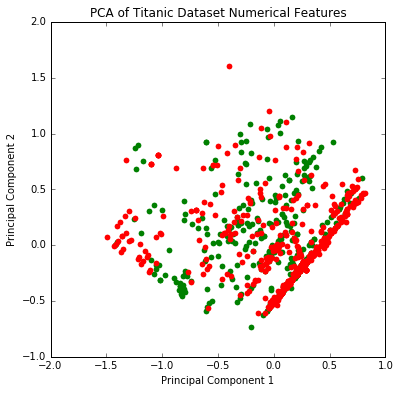

In [12]:
#%% PCA Visualization

pca = PCA(n_components=2)
pca.fit(df[numerical_features])
print '% Explained variance: ', pca.explained_variance_ratio_.cumsum()[-1]*100
df_prin = pd.DataFrame(pca.transform(df[numerical_features]), columns=['Prin1', 'Prin2'], index=df.index)
df = pd.concat((df, df_prin), axis=1)


survived_groups = df.groupby('Survived')
non_survived = survived_groups.get_group(0) 
survived = survived_groups.get_group(1) 

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(survived['Prin1'], survived['Prin2'], color='g', label='Survived')
ax.scatter(non_survived['Prin1'], non_survived['Prin2'], color='r', label='Non-Survived')
ax.set_title('PCA of Titanic Dataset Numerical Features')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

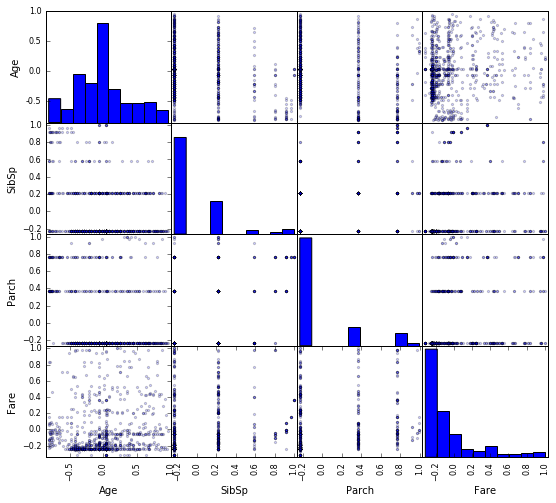

In [13]:
#%% Scatter Matrix

sm = scatter_matrix(df[numerical_features], alpha=0.2, figsize=(9,8), diagonal='hist')